# CSE-144-01 - 2025 Winter - HW 1

## Instruction

- Submit your assignments onto **Canvas** by the due date. Upload a single `.ipynb` file with all the necessary output.
- Don't use any magic function from other libraries. You will get **no credit** if a Gradient Descent function from a known library is used when you are asked to implement **Linear Regression** or **Linear Classifcation**.
- Don't change the input and output structure of pre-defined functions. Only write your code between `YOUR CODE STARTS HERE` and `YOUR CODE ENDS HERE`. You won't get the points if you alter the code outside these two dividing lines. Most coding parts can be finished with about 5-6 lines of codes.
- Make sure you have installed required packages imported in the first code block.

## Rubric

The assignment is worth 75pts in total:
- Data Preprocessing (12pts)
    - Remove Missing Values (2pts)
    - Remove outliers (5pts)
    - Normalization (5pts)
- Dataset Preparation (11pts)
    - Build TrainVal/Test Set `test_split` (5pts)
    - K-fold Cross Validation `train_val_split` (6pts)
- Linear Regression (26pts)
    - `mean_square_error_loss` (3pts)
    - `mse_gradient` (5pts)
    - Hyper-Parameters Tuning (6pts)
    - Traininig (10pts)
        - Translate Dataframe to Numpy (3pts)
        - Theta Initialization (1pt)
        - Loss Computation (3pts)
        - Gradient Descent (3pts)
    - Evaluation on test set (2pts)
- Linear Classification with Logistic Regression (26pts)
    - `sigmoid` (1pt)
    - `binary_cross_entrophy_loss` (3pts)
    - `bce_gradient` (5pts)
    - Hyper-Parameters Tuning (6pts)
    - Traininig (9pts)
        - `accuracy` (1pt)
        - Translate Dataframe to Numpy (2pts)
        - Theta Initialization (1pt)
        - Loss and ACC Computation (3pts)
        - Gradient Descent (2pts)
    - Evaluation on test set (2pts)

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Load the dataset

In [2]:
data_red = pd.read_csv("winequality-red-new.csv")
data_white = pd.read_csv("winequality-white-new.csv")

data_red["wine_type"] = 1
data_white["wine_type"] = 0

data = pd.concat([data_red, data_white], axis=0)

### Visualize data

<class 'pandas.core.frame.DataFrame'>
Index: 3199 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3164 non-null   float64
 1   volatile acidity      3172 non-null   float64
 2   citric acid           3170 non-null   float64
 3   residual sugar        3171 non-null   float64
 4   chlorides             3170 non-null   float64
 5   free sulfur dioxide   3171 non-null   float64
 6   total sulfur dioxide  3166 non-null   float64
 7   density               3179 non-null   float64
 8   pH                    3175 non-null   float64
 9   sulphates             3179 non-null   float64
 10  alcohol               3171 non-null   float64
 11  quality               3155 non-null   float64
 12  wine_type             3199 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 349.9 KB


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>],
       [<Axes: title={'center': 'wine_type'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

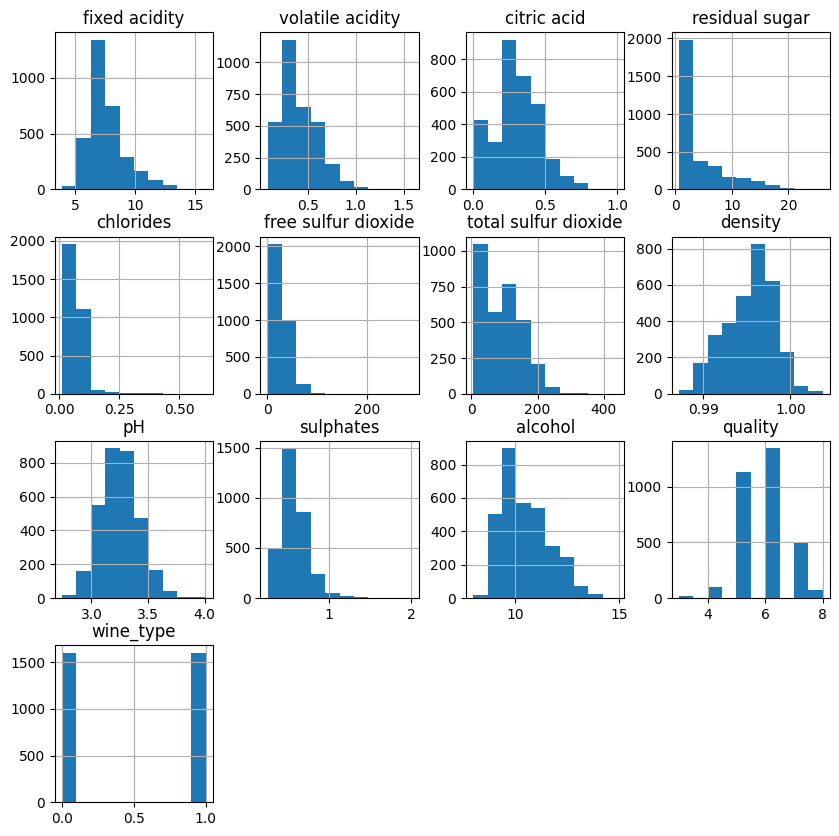

In [3]:
data.info()
data.hist(figsize=(10, 10))

## Data Preprocessing (12pts)
`data.info()` shows that there are some missing values in the dataset. Also, we can see from the histogram that outliers exist for some features. Moreover, the range of different features has a huge gap: from (0, 1), to (0, 300). In the following you need to perform:
1. Drop rows that contain NULL values.
2. Remove outliers for features in `['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'residual sugar']` based on interquantile range.
3. Normalize of features using Z-score method.

### Remove Missing Values (2pts)
Drop rows that have NULL values

In [4]:
# ========== YOUR CODE STARTS HERE ==========
data = data.dropna()
# ========== YOUR CODE ENDS HERE ============

print(data.shape)

(2872, 13)


### Remove Outliers (5pts)
Remove outliers for features in `['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'residual sugar']` based on interquantile range. Here for each feature, we first sort data in an ascending order.

Let q1 and q3 be the data that ranks 25% and 75% respectively. We then let `iqr = q3 - q1`, and
compute
```
a = q1 - iqr x 1.5
b = q3 + iqr x 1.5
```
and remove the data out of the range [a, b].

Note: this can be realized with function `pd.DataFrame.quantile()`.

In [5]:
def remove_outliers(data):
    for feature in ['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'residual sugar']:
        # ========== YOUR CODE STARTS HERE ==========
        q1 = data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        iqr = q3 - q1
        a = q1 - 1.5 * iqr
        b = q3 + 1.5 * iqr
        data = data[(data[feature] >= a) & (data[feature] <= b)]
        # ========== YOUR CODE ENDS HERE ============

    return data


data_cleaned = remove_outliers(data)
print(data_cleaned.shape)

(2437, 13)


### Normalization (5pts)
Scale all features using z-score normalization.

`quality` is the target for linear regression. Scale the `quality` from `[0, 10]` to `[0, 1]` for easier convergence.

`wine_type` is the target for linear classification. No normalization is needed for `wine_type` as it is already binary.

Note: use different mean and std for different feature.

In [6]:
# ========== YOUR CODE STARTS HERE ==========
data_normalized = data_cleaned.copy()

for col in data_normalized.columns:
    if col not in ["quality", "wine_type"]:
        mean = data_normalized[col].mean()
        std = data_normalized[col].std()
        data_normalized[col] = (data_normalized[col] - mean) / std

data_normalized["quality"] = data_cleaned["quality"] / 10
# ========== YOUR CODE ENDS HERE ============

print("Mean\n", data_normalized.mean(axis=0))
print("STD\n", data_normalized.std(axis=0))

assert np.isclose(data_normalized.drop(columns=["quality", "wine_type"]).mean(axis=0), 0).all()
assert np.isclose(data_normalized.drop(columns=["quality", "wine_type"]).std(axis=0), 1).all()
assert data_normalized["wine_type"].apply(lambda x: x in [0, 1]).all()
assert data_normalized["quality"].apply(lambda x: 0 <= x and x <= 1).all()

Mean
 fixed acidity          -2.799019e-16
volatile acidity       -9.330065e-17
citric acid            -1.166258e-17
residual sugar          0.000000e+00
chlorides               1.399510e-16
free sulfur dioxide     0.000000e+00
total sulfur dioxide    4.665032e-17
density                -3.634060e-14
pH                     -1.982639e-15
sulphates              -3.265523e-16
alcohol                -1.341197e-15
quality                 5.773902e-01
wine_type               5.367255e-01
dtype: float64
STD
 fixed acidity           1.000000
volatile acidity        1.000000
citric acid             1.000000
residual sugar          1.000000
chlorides               1.000000
free sulfur dioxide     1.000000
total sulfur dioxide    1.000000
density                 1.000000
pH                      1.000000
sulphates               1.000000
alcohol                 1.000000
quality                 0.085347
wine_type               0.498752
dtype: float64


Now we visualize the data again.

<class 'pandas.core.frame.DataFrame'>
Index: 2437 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2437 non-null   float64
 1   volatile acidity      2437 non-null   float64
 2   citric acid           2437 non-null   float64
 3   residual sugar        2437 non-null   float64
 4   chlorides             2437 non-null   float64
 5   free sulfur dioxide   2437 non-null   float64
 6   total sulfur dioxide  2437 non-null   float64
 7   density               2437 non-null   float64
 8   pH                    2437 non-null   float64
 9   sulphates             2437 non-null   float64
 10  alcohol               2437 non-null   float64
 11  quality               2437 non-null   float64
 12  wine_type             2437 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 266.5 KB


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>],
       [<Axes: title={'center': 'wine_type'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

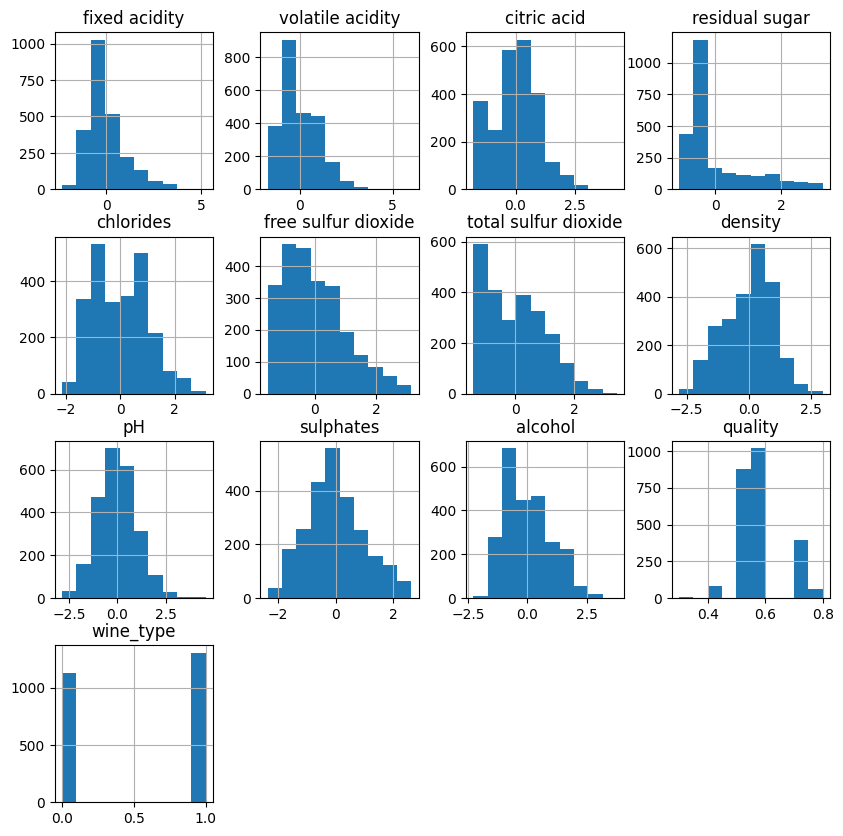

In [7]:
data_normalized.info()
data_normalized.hist(figsize=(10, 10))

## Dataset Preparation (11pts)
Next we will split dataset to train set, validation set and test set. First we randomly choose 20% as test set. Then we use $k$-fold validation on the remaining 80% to generate $k$ different train set and validation set pairs, where $k=5$.

In [8]:
# 5pts
def test_split(data, test_ratio=0.2, seed=SEED):
    '''
    Use function `train_test_split` to split test set.
    '''
    # ========== YOUR CODE STARTS HERE ==========
    x = data.drop(columns = ["quality", "wine_type"])
    y = data[["quality", "wine_type"]]

    x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size = test_ratio, random_state = seed)
    # ========== YOUR CODE ENDS HERE ============

    return (x_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            x_test.reset_index(drop=True),
            y_test.reset_index(drop=True))


# 6pts
def train_val_split(x_train_val, y_train_val, k=5):
    '''
    Use given index sets to generate k train and validation pairs. The return value should be
    a list whose components are tuples:
    [(x_train1, y_train1, x_val1, y_val1), ..., (x_traink, y_traink, x_valk, y_valk)]

    Each x_traink/y_traink/x_valk/y_valk is a pd.DataFrame

    '''
    index_shuffle = list(x_train_val.index)
    random.shuffle(index_shuffle)

    # This is the indices for the validation set for each fold
    val_indices_list = [
        [
            index_shuffle[i + fold_i]
            for i in range(0, len(index_shuffle), k) if i + fold_i < len(index_shuffle)
        ]
        for fold_i in range(k)
    ]

    train_val_list = []
    # ========== YOUR CODE STARTS HERE ==========
    for val_indices in val_indices_list:
        train_indices = list(set(x_train_val.index) - set(val_indices))
        x_train = x_train_val.loc[train_indices]
        y_train = y_train_val.loc[train_indices]
        x_val = x_train_val.loc[val_indices]
        y_val = y_train_val.loc[val_indices]
        train_val_list.append((x_train, y_train, x_val, y_val))
    # ========== YOUR CODE ENDS HERE ============
    return train_val_list


K = 5
x_train_val, y_train_val, x_test, y_test = test_split(data_normalized, test_ratio=0.2)
train_val_list = train_val_split(x_train_val, y_train_val, k=K)

assert len(train_val_list) == K and {len(fold) for fold in train_val_list} == {4}

## Linear Regression (26pts)

Use linear regression to prediction `quality`.

In [9]:
# 3pts
def mean_square_error_loss(pred: np.ndarray, target: np.ndarray):
    # Normalized by pred.shape[0]

    # ========== YOUR CODE STARTS HERE ==========
    return np.mean((pred - target) ** 2)
    # ========== YOUR CODE ENDS HERE ============


# 5pts
def mse_gradient(X: np.ndarray, target: np.ndarray, theta: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    n = X.shape[0]
    return (2 / n) * X.T.dot(X.dot(theta) - target)
    # ========== YOUR CODE ENDS HERE ============

In [10]:
theta_dummy = np.linspace(1, -1, 64)
x_dummy = np.ones((8, 64))
pred_dummy = x_dummy @ theta_dummy
target_dummy =  np.linspace(1, 0, 8)
print("Dummy Loss:", mean_square_error_loss(pred_dummy, target_dummy))
print("Dummy Gradient Mean & STD:", mse_gradient(x_dummy, target_dummy, theta_dummy).mean(), mse_gradient(x_dummy, target_dummy, theta_dummy).std())

Dummy Loss: 0.35714285714285343
Dummy Gradient Mean & STD: -0.9999999999999927 1.1102230246251565e-16


### Hyper-Parameters Tuning (6pts)

You need to reach an averaged final MSE < 0.05 on 5-fold validation sets to get points for this part.

In [11]:
# ========== YOUR CODE STARTS HERE ==========
num_epochs = 10000
learning_rate = 0.01

fold_mse_list = []

for x_train, y_train, x_val, y_val in train_val_list:
    y_train_quality = y_train["quality"].values
    y_val_quality = y_val["quality"].values

    X_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train.values])
    X_val = np.hstack([np.ones((x_val.shape[0], 1)), x_val.values])

    theta = np.zeros(X_train.shape[1])

    for epoch in range(num_epochs):
        grad = mse_gradient(X_train, y_train_quality, theta)
        theta = theta - learning_rate * grad

    val_pred = X_val.dot(theta)
    mse_val = mean_square_error_loss(val_pred, y_val_quality)
    fold_mse_list.append(mse_val)

avg_mse = np.mean(fold_mse_list)
print("Average Final MSE on 5-fold validation sets: ", avg_mse)
# ========== YOUR CODE ENDS HERE ============

Average Final MSE on 5-fold validation sets:  0.004717984763379286


### Training (10pts)

Hint: A convenient way to calculate $X \cdot \theta$ is to prepend a column of 1's to your $X$ matrix so that you don't have to perform an extra addition operation for the bias.

If you decide to use this implementation, add an additional dimension to your feature matrix so that they are consistent in shape. See the image below for illustration. See this [illustration](https://cs231n.github.io/linear-classify/#:~:text=Illustration%20of%20the,and%20the%20biases.) for more detail.

You report should include the train, val and test loss. You can try different learning rates and epoch combinations and report the best results you get based on the validation loss.

In [12]:
train_losses_folds = [[] for _ in range(K)]
val_losses_folds = [[] for _ in range(K)]

thetas = []

for i in range(K):
    x_train, y_train, x_val, y_val = train_val_list[i]

    y_train = y_train["quality"]
    y_val = y_val["quality"]

    # Translate pd.DataFrame to numpy (3pt)
    # ========== YOUR CODE STARTS HERE ==========
    X_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train.values])
    X_val = np.hstack([np.ones((x_val.shape[0], 1)), x_val.values])
    y_train_np = y_train.values
    y_val_np = y_val.values
    # ========== YOUR CODE ENDS HERE ============

    # Initialize theta (1pt)
    # ========== YOUR CODE STARTS HERE ==========
    theta = np.zeros(X_train.shape[1])
    # ========== YOUR CODE ENDS HERE ============

    for epoch in trange(num_epochs, desc="Epoch"):
        # Compute loss, and save to train_losses_folds and val_losses_folds (3pts)
        # ========== YOUR CODE STARTS HERE ==========
        train_pred = X_train.dot(theta)
        train_loss = mean_square_error_loss(train_pred, y_train_np)
        val_pred = X_val.dot(theta)
        val_loss = mean_square_error_loss(val_pred, y_val_np)
        train_losses_folds[i].append(train_loss)
        val_losses_folds[i].append(val_loss)
        # ========== YOUR CODE ENDS HERE ============

        # Gradient descent (3pts)
        # ========== YOUR CODE STARTS HERE ==========
        grad = mse_gradient(X_train, y_train_np, theta)
        theta = theta - learning_rate * grad
        # ========== YOUR CODE ENDS HERE ============

    # Save trained theta
    thetas.append(theta)


Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Averaged final training loss: 0.004641966620501434
Averaged final validation loss: 0.004717984753420948


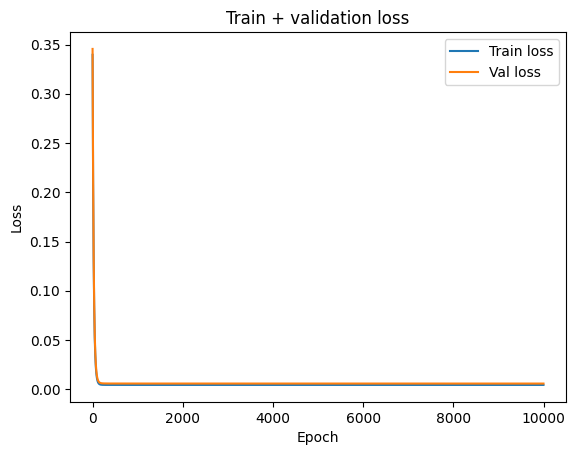

In [13]:
print(f"Averaged final training loss: {sum([train_losses[-1] for train_losses in train_losses_folds]) / len(train_losses_folds)}")
print(f"Averaged final validation loss: {sum([val_losses[-1] for val_losses in val_losses_folds]) / len(val_losses_folds)}")

plt.plot(np.arange(num_epochs), train_losses_folds[0], label="Train loss")
plt.plot(np.arange(num_epochs), val_losses_folds[0], label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation on Test Set (3pts)

Average the predictions from thetas from each fold as the final prediction

In [14]:
def inference_final(x_test, thetas):
    # ========== YOUR CODE STARTS HERE ==========
    x_test_np = np.hstack([np.ones((x_test.shape[0], 1)), x_test.values])
    preds = [x_test_np.dot(theta) for theta in thetas]
    final_pred = np.mean(preds, axis = 0)
    return final_pred
    # ========== YOUR CODE ENDS HERE ============


test_pred = inference_final(x_test, thetas)
test_loss = mean_square_error_loss(test_pred, y_test["quality"])
print(f"Test loss: {test_loss}")

Test loss: 0.004758549727695322


## Linear Classification with Logistic Regression (26pts)

Use Logistic Regression to prediction `wine_type`.

In [15]:
# 1pt
def sigmoid(logit):
    # ========== YOUR CODE STARTS HERE ==========
    return 1/ (1 + np.exp(-logit))
    # ========== YOUR CODE ENDS HERE ============


# 3pts
def binary_cross_entrophy_loss(pred, target):
    # Normalized by pred.shape[0]

    # ========== YOUR CODE STARTS HERE ==========
    return np.mean(- (target * np.log(pred) + (1 - target) * np.log(1 - pred)))
    # ========== YOUR CODE ENDS HERE ============


# 5pts
def bce_gradient(X, target, theta):
    # ========== YOUR CODE STARTS HERE ==========
    n = X.shape[0]
    pred = sigmoid(X.dot(theta))
    return X.T.dot(pred - target) / n
    # ========== YOUR CODE ENDS HERE ============

In [16]:
theta_dummy = np.linspace(1, -1, 64)
x_dummy = np.ones((8, 64))
pred_dummy = sigmoid(x_dummy @ theta_dummy)
target_dummy =  np.linspace(1, 0, 8)
print("Dummy Loss:", binary_cross_entrophy_loss(pred_dummy, target_dummy))
print("Dummy Gradient Mean & STD:", bce_gradient(x_dummy, target_dummy, theta_dummy).mean(), bce_gradient(x_dummy, target_dummy, theta_dummy).std())

Dummy Loss: 0.6931471805599453
Dummy Gradient Mean & STD: 9.992007221626409e-16 0.0


### Hyper-Parameters (6pts)

You need to reach an averaged final ACC > 0.85 on 5-fold validation sets to get points for this part.

In [17]:
prob_threshold = 0.5
# ========== YOUR CODE STARTS HERE ==========
num_epochs_class = 10000
learning_rate_class = 0.01
acc_list = []
for i in range(K):

    x_train, y_train, x_val, y_val = train_val_list[i]
    y_train_class = y_train["wine_type"].values
    y_val_class = y_val["wine_type"].values
    
    X_train_class = np.hstack([np.ones((x_train.shape[0], 1)), x_train.values])
    X_val_class = np.hstack([np.ones((x_val.shape[0], 1)), x_val.values])
    
    theta_class = np.zeros(X_train_class.shape[1])
    
    for epoch in range(num_epochs_class):
        pred_train_class = sigmoid(X_train_class.dot(theta_class))
        grad_class = bce_gradient(X_train_class, y_train_class, theta_class)
        theta_class = theta_class - learning_rate_class * grad_class

    pred_val_class = sigmoid(X_val_class.dot(theta_class))
    pred_val_labels = (pred_val_class >= prob_threshold).astype(int)
    acc = np.mean(pred_val_labels == y_val_class)
    acc_list.append(acc)

avg_acc = np.mean(acc_list)
print("Final Averaged Validation Accuracy:", avg_acc)
# ========== YOUR CODE ENDS HERE ============

Final Averaged Validation Accuracy: 0.9928139212972118


### Training (9pts)

In [18]:
# 1pt
def accuracy(pred, target):
    # compute accuracy with predicted probability, target, and `prob_threshold` defined in the previous block
    # ========== YOUR CODE STARTS HERE ==========
    pred_labels = (pred >= prob_threshold).astype(int)
    return np.mean(pred_labels == target)
    # ========== YOUR CODE ENDS HERE ============


train_losses_folds = [[] for _ in range(K)]
val_losses_folds = [[] for _ in range(K)]

train_accs_folds = [[] for _ in range(K)]
val_accs_folds = [[] for _ in range(K)]

thetas = []

for i in range(K):
    x_train, y_train, x_val, y_val = train_val_list[i]

    y_train = y_train["wine_type"]
    y_val = y_val["wine_type"]

    # Translate pd.DataFrame to numpy (2pts)
    # ========== YOUR CODE STARTS HERE ==========
    X_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train.values])
    X_val = np.hstack([np.ones((x_val.shape[0], 1)), x_val.values])
    y_train_np = y_train.values
    y_val_np = y_val.values
    # ========== YOUR CODE ENDS HERE ============

    # Initialize theta (1pt)
    # ========== YOUR CODE STARTS HERE ==========
    theta = np.zeros(X_train.shape[1])
    # ========== YOUR CODE ENDS HERE ============

    for epoch in trange(num_epochs, desc="Epoch"):
        # Compute loss, and save to train_losses_folds and val_losses_folds
        # Compute accuracy, and save to train_accs_folds and val_accs_folds
        # 3pts
        # ========== YOUR CODE STARTS HERE ==========
        pred_train = sigmoid(X_train.dot(theta))
        loss_train = binary_cross_entrophy_loss(pred_train, y_train_np)
        acc_train = accuracy(pred_train, y_train_np)
        train_losses_folds[i].append(loss_train)
        train_accs_folds[i].append(acc_train)
        
        pred_val = sigmoid(X_val.dot(theta))
        loss_val = binary_cross_entrophy_loss(pred_val, y_val_np)
        acc_val = accuracy(pred_val, y_val_np)
        val_losses_folds[i].append(loss_val)
        val_accs_folds[i].append(acc_val)
        # ========== YOUR CODE ENDS HERE ============

        # Gradient descent (2pts)
        # ========== YOUR CODE STARTS HERE ==========
        grad = bce_gradient(X_train, y_train_np, theta)
        theta = theta - learning_rate_class * grad
        # ========== YOUR CODE ENDS HERE ============

    # Save trained theta
    thetas.append(theta)


Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Averaged final training loss: 0.04853454581725596
Averaged final validation loss: 0.052192312574399935
Averaged final training ACC: 0.9932014276080985
Averaged final validation ACC: 0.9928139212972118


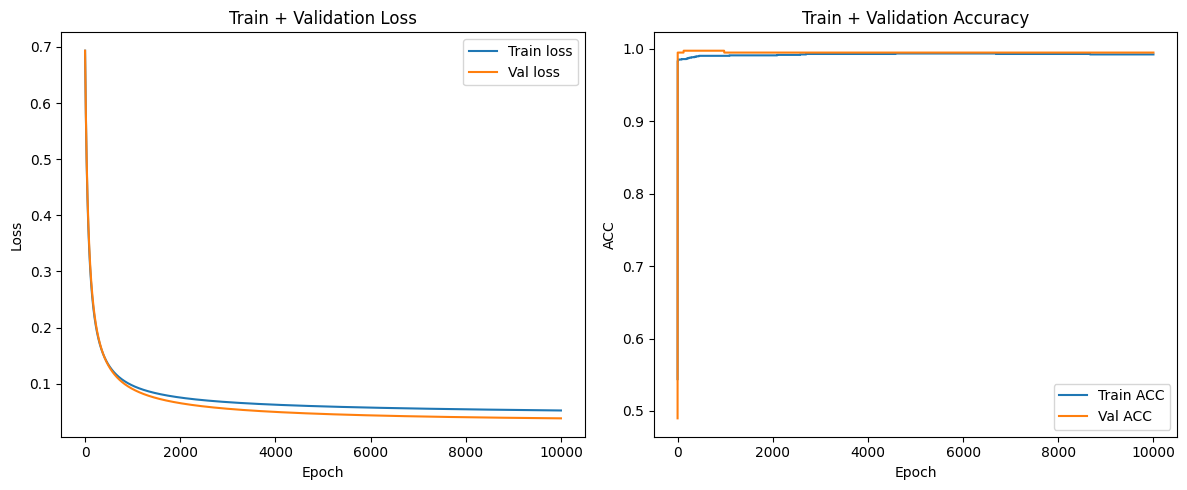

In [19]:
print(f"Averaged final training loss: {sum([train_losses[-1] for train_losses in train_losses_folds]) / len(train_losses_folds)}")
print(f"Averaged final validation loss: {sum([val_losses[-1] for val_losses in val_losses_folds]) / len(val_losses_folds)}")
print(f"Averaged final training ACC: {sum([train_accs[-1] for train_accs in train_accs_folds]) / len(train_accs_folds)}")
print(f"Averaged final validation ACC: {sum([val_accs[-1] for val_accs in val_accs_folds]) / len(val_accs_folds)}")

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

axes[0].plot(np.arange(num_epochs), train_losses_folds[0], label="Train loss")
axes[0].plot(np.arange(num_epochs), val_losses_folds[0], label="Val loss")
axes[0].set_title("Train + Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(np.arange(num_epochs), train_accs_folds[0], label="Train ACC")
axes[1].plot(np.arange(num_epochs), val_accs_folds[0], label="Val ACC")
axes[1].set_title("Train + Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("ACC")
axes[1].legend()

plt.tight_layout()
plt.show()

### Evaluation on Test Set (2pts)

Average the predictions from thetas from each fold as the final prediction.

In [20]:
def inference_final(x_test, thetas):
    # ========== YOUR CODE STARTS HERE ==========
    X_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test.values])
    preds = [sigmoid(X_test.dot(theta)) for theta in thetas]
    avg_pred = np.mean(preds, axis = 0)
    return avg_pred
    # ========== YOUR CODE ENDS HERE ============


test_pred = inference_final(x_test, thetas)
test_loss = accuracy(test_pred, y_test["wine_type"])
print(f"Test ACC: {test_loss}")

Test ACC: 0.9959016393442623
